
# Problem Statement

### Credit Card Lead Prediction
Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.
The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 
In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

* Customer details (gender, age, region etc.)

* Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

## Data Dictionary:-

**Train Data**

Variable | Definition
------ | ------
ID | Unique Identifier for a row
Gender | Gender of the Customer
Age | Age of the Customer (in Years)
Region_Code | Code of the Region for the customers
Occupation | Occupation Type for the customer
Channel_Code | Acquisition Channel Code for the Customer  (Encoded)
Vintage | Vintage for the Customer (In Months)
Credit_Product | If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.)
Avg_Account_Balance | Average Account Balance for the Customer in last 12 Months
Is_Active | If the Customer is Active in last 3 Months
Is_Lead(Target) | If the Customer is interested for the Credit Card (0 : Customer is not interested,1 : Customer is interested)


**Test Data**

Variable | Definition
------ | ------
ID | Unique Identifier for a row
Gender | Gender of the Customer
Age | Age of the Customer (in Years)
Region_Code | Code of the Region for the customers
Occupation | Occupation Type for the customer
Channel_Code | Acquisition Channel Code for the Customer  (Encoded)
Vintage | Vintage for the Customer (In Months)
Credit_Product | If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.)
Avg_Account_Balance | Average Account Balance for the Customer in last 12 Months
Is_Active | If the Customer is Active in last 3 Months


## Sample Submission:-
This file contains the exact submission format for the predictions. Please submit CSV file only.

Variable | Definition
------ | ------
ID | Unique Identifier for a row
Is_Lead | (Target)  Probability of Customer showing interest (class 1)



In [80]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import random
pd.set_option('display.max_columns', None)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

# Machine Learning
# Utils
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn import preprocessing
#Feature Selection
from sklearn.feature_selection import chi2, f_classif, f_regression, mutual_info_classif
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile
from sklearn.feature_selection import VarianceThreshold
# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
#!pip install imblearn
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
# Unsupervised Models
from sklearn.cluster import KMeans
#Metrics
from sklearn.metrics import roc_auc_score

# Fixing Seed
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything()

In [81]:
#data_dir = 'C:/Users/ayush.chaturvedi/Downloads'

#train_file_path = os.path.join(data_dir, 'train_s3TEQDk_IyaGz9Y_h2PVtrJ.csv')
#test_file_path = os.path.join(data_dir, 'test.csv')
#sample_sub_file_path = os.path.join(data_dir, 'sample_submission.csv')

#print(f'Train file: {train_file_path}')
#print(f'Train file: {test_file_path}')
#print(f'Train file: {sample_sub_file_path}')

# EDA
Let's have a basic look around the data we have at hand first

In [82]:
train_df = pd.read_csv("C:/Users/ayush.chaturvedi/Downloads/train_s3TEQDk_IyaGz9Y_h2PVtrJ.csv")
test_df = pd.read_csv("C:/Users/ayush.chaturvedi/Downloads/test_mSzZ8RL_DKa2Eez_ZqNXZG8.csv")
sub_df = pd.read_csv("C:/Users/ayush.chaturvedi/Downloads/sample_submission_eyYijxG_UYrG05O_mfI9LlW.csv")

Let's see what columns we have in the training data.

In [83]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [84]:
train_df.tail()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0
245724,BOCZSWLJ,Male,29,RG269,Salaried,X1,21,No,1129276,No,0


In [85]:
train_df.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

From the column keys in problem statement we know the following information about each of the features:-

 Variable      | Definition         
 :-----------  |:------------
 ID | Unique Identifier for a row
 Gender | Gender of the Customer
 Age | Age of the Customer (in Years)
 Region_Code | Code of the Region for the customers
 Occupation | Occupation Type for the customer
 Channel_Code | Acquisition Channel Code for the Customer  (Encoded)
 Vintage | Vintage for the Customer (In Months)
 Credit_Product | If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.)
 Avg_Account_Balance | Average Account Balance for the Customer in last 12 Months
 Is_Active | If the Customer is Active in last 3 Months
 Is_Lead(Target) | 0 : Customer is not interested
 | 1 : Customer is interested

We can get a naive idea about the type of variables form the definition itself and looking at the data makes it clearer.

In [86]:
train_df.shape,test_df.shape

((245725, 11), (105312, 10))

In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [88]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [89]:
train_df.describe(include=[np.number]).round(2) 

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.00,245725.00,245725.00,245725.00
mean,43.86,46.96,1128403.10,0.24
std,14.83,32.35,852936.36,0.43
min,23.00,7.00,20790.00,0.00
25%,30.00,20.00,604310.00,0.00
50%,43.00,32.00,894601.00,0.00
75%,54.00,73.00,1366666.00,0.00
max,85.00,135.00,10352009.00,1.00


In [90]:
np.sum(train_df.isnull())

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

We can see that there are some Null values in some columns. Which is not good for data ingestion into any model, so let's see the Null situation upfront:-  
## 1. Null Values

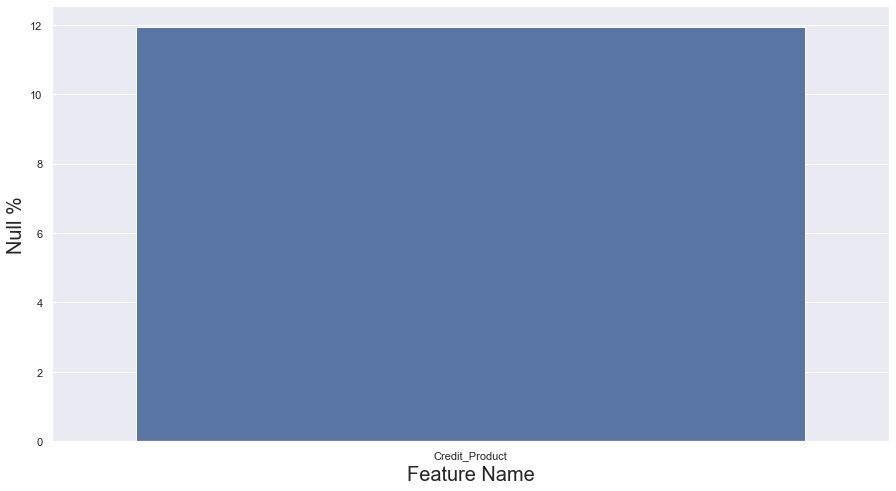

In [91]:
Null_in_train = np.sum(train_df.isnull())
null_col_train = Null_in_train.loc[(Null_in_train != 0)].sort_values(ascending=False)
null_col_train = null_col_train.apply(lambda x: 100*x/train_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=null_col_train.index, y=null_col_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

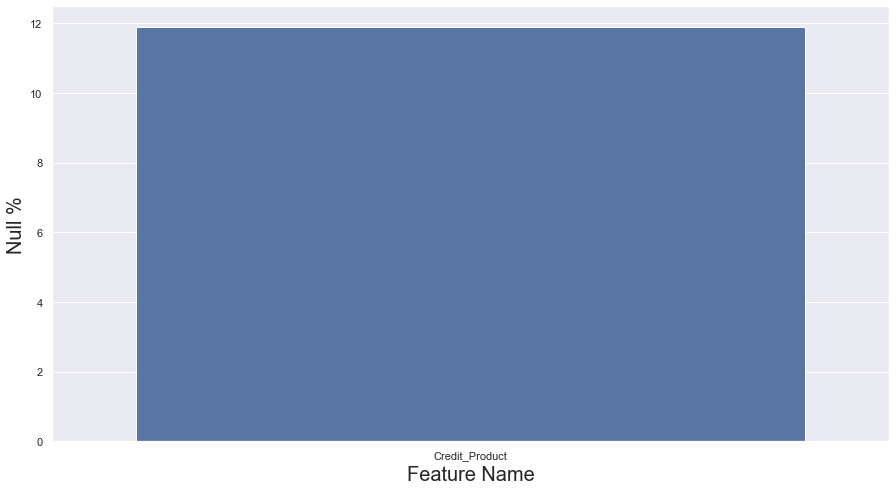

In [92]:
Null_in_test = np.sum(test_df.isnull())
null_col_test = Null_in_test.loc[(Null_in_test != 0)].sort_values(ascending=False)
null_col_test = null_col_test.apply(lambda x: 100*x/test_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=null_col_test.index, y=null_col_test)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

The situation is almost similar in both train set and test set; Around 12% of the values from 'Credit_Product' column is missing. And looking at the feature definition of the missing column we can assume that the NaN values in credit product means we do not know is the user has/does not have any active credit product. So, we can replace Nan with 'Unknown' and create another binary column to track the same:-

In [93]:
train_df['Credit_Product'].fillna('Unk', inplace=True)
test_df['Credit_Product'].fillna('Unk', inplace=True)

In [94]:
train_df['Credit_Product_Known'] = train_df['Credit_Product'].apply(lambda x: 0 if x == 'Unk' else 1)
test_df['Credit_Product_Known'] = test_df['Credit_Product'].apply(lambda x: 0 if x == 'Unk' else 1)
# We created a new column to check whether the data is missing or not. In this case the value is simple 0 and 1.
#Value is 0 if the value in the credit_product column is 'Unk' otherwise it is 1.

In [95]:
np.sum(train_df.isnull())

ID                      0
Gender                  0
Age                     0
Region_Code             0
Occupation              0
Channel_Code            0
Vintage                 0
Credit_Product          0
Avg_Account_Balance     0
Is_Active               0
Is_Lead                 0
Credit_Product_Known    0
dtype: int64

In [96]:
np.sum(test_df.isnull())

ID                      0
Gender                  0
Age                     0
Region_Code             0
Occupation              0
Channel_Code            0
Vintage                 0
Credit_Product          0
Avg_Account_Balance     0
Is_Active               0
Credit_Product_Known    0
dtype: int64

Now that we have resolved all the null values, let's move on to EDA starting with class imabalance of the Dataset.
## 2. Class Imbalance
As this is a classification problem, let's start from the population of each class in out training set.

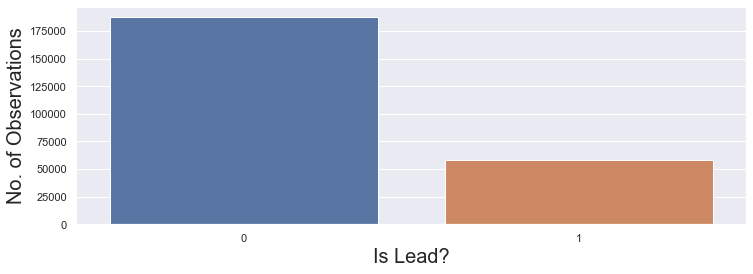

In [97]:
ax = plt.subplots(figsize=(12, 4))
sns.set_style("darkgrid")
sns.countplot(x='Is_Lead', data=train_df);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Is Lead?", size=20);

In [98]:
imbalance_ratio = train_df[train_df['Is_Lead'] == 0].shape[0]/train_df[train_df['Is_Lead'] == 1].shape[0]
print(f'Imbalance ratio: {imbalance_ratio}')

Imbalance ratio: 3.215704776283283


Okay, so it is an imbalanced set. We have to keep that in mind while modelling and choosing hyper-parameters later.  

## 3. Feature Value Counts
Let's see how many unique values are there in each feature.

In [99]:
train_df.nunique()

ID                      245725
Gender                       2
Age                         63
Region_Code                 35
Occupation                   4
Channel_Code                 4
Vintage                     66
Credit_Product               3
Avg_Account_Balance     135292
Is_Active                    2
Is_Lead                      2
Credit_Product_Known         2
dtype: int64

In [100]:
train_df.shape

(245725, 12)

There are a mix of certain continuous, high cardinality categorical and low cardinality categorical features.

Now let's look at each individual feature separately and undersatnd the data...
## 4. Gender
This feature contains the Gender data of the customer

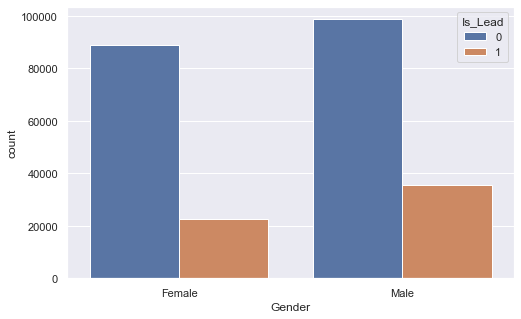

In [101]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(x='Gender', hue='Is_Lead', data=train_df);

In [102]:
# Response Rate from Gender
v = train_df.groupby('Gender').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)
# we create a new variable here names v which calculates the reponse ratio of each gender using group by function. 
# we check for value 1 in the 0 amd 1 of both genders 

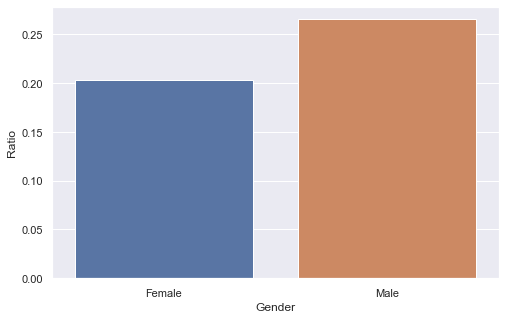

In [103]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("darkgrid")
sns.barplot(x='Gender', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=True));

* There are more number of observations from Male customers as compared to Female customers in the training data.
* According to the dataset, Male gender has better conversion ratio than Female gender.

## 5. Age
Age of the Customer (in Years)

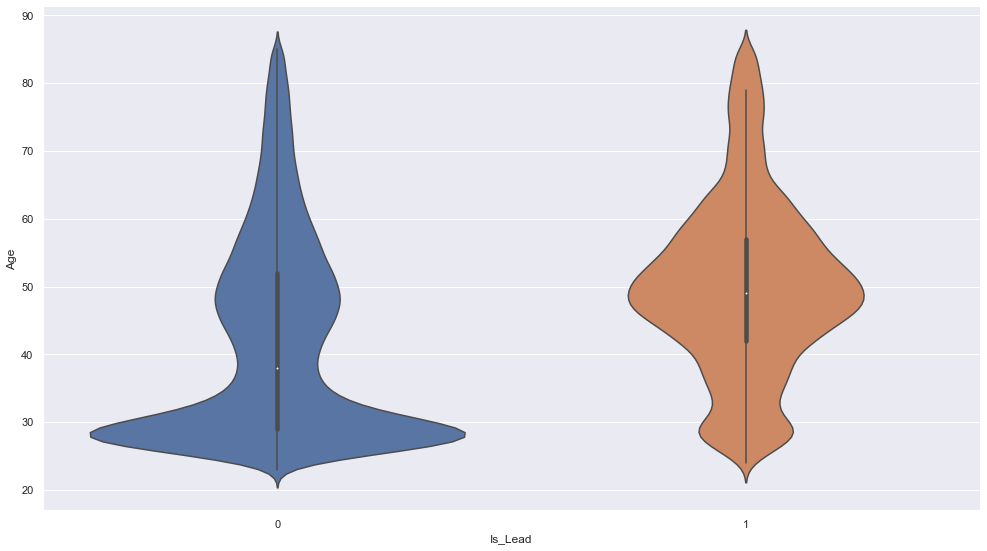

In [104]:
g = sns.catplot(x='Is_Lead', y='Age', kind='violin', data=train_df);
g.fig.set_size_inches(15,8)

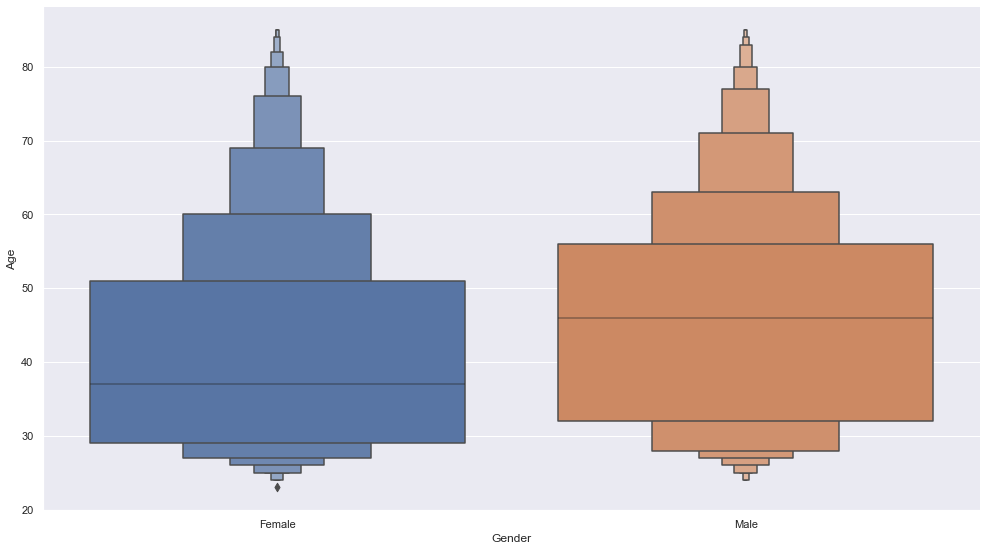

In [105]:
g = sns.catplot(x='Gender', y='Age', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)

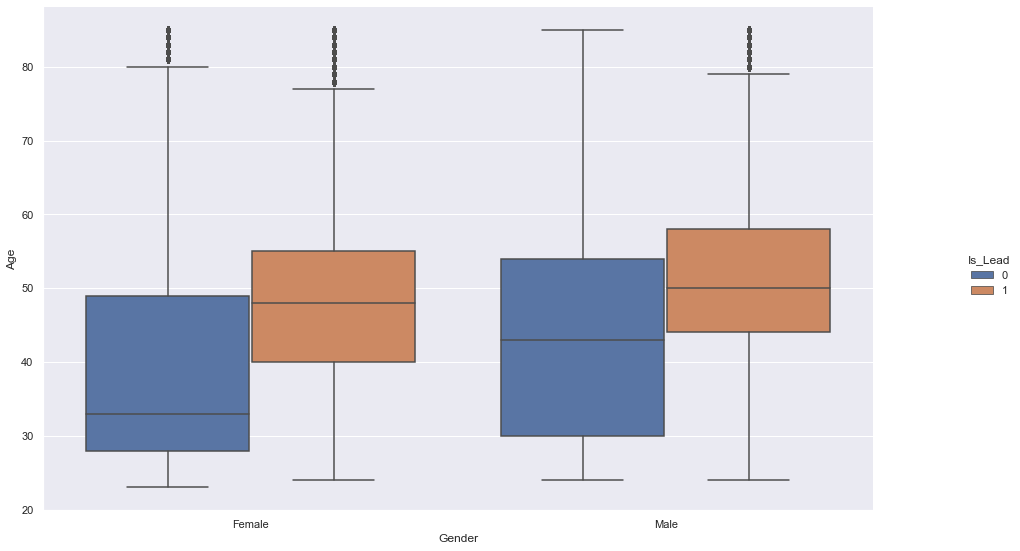

In [106]:
g = sns.catplot(x='Gender', y='Age', hue='Is_Lead', kind='box', data=train_df);
g.fig.set_size_inches(15,8)

* On an average, more aged people are likely to respond positively to our offer.
* The average age of male in dataset is > average age of female.
* If we split by gender, the average age of positively responding male is > average of positively responding Female.

## 6. Region Code
Code of the Region for the customers

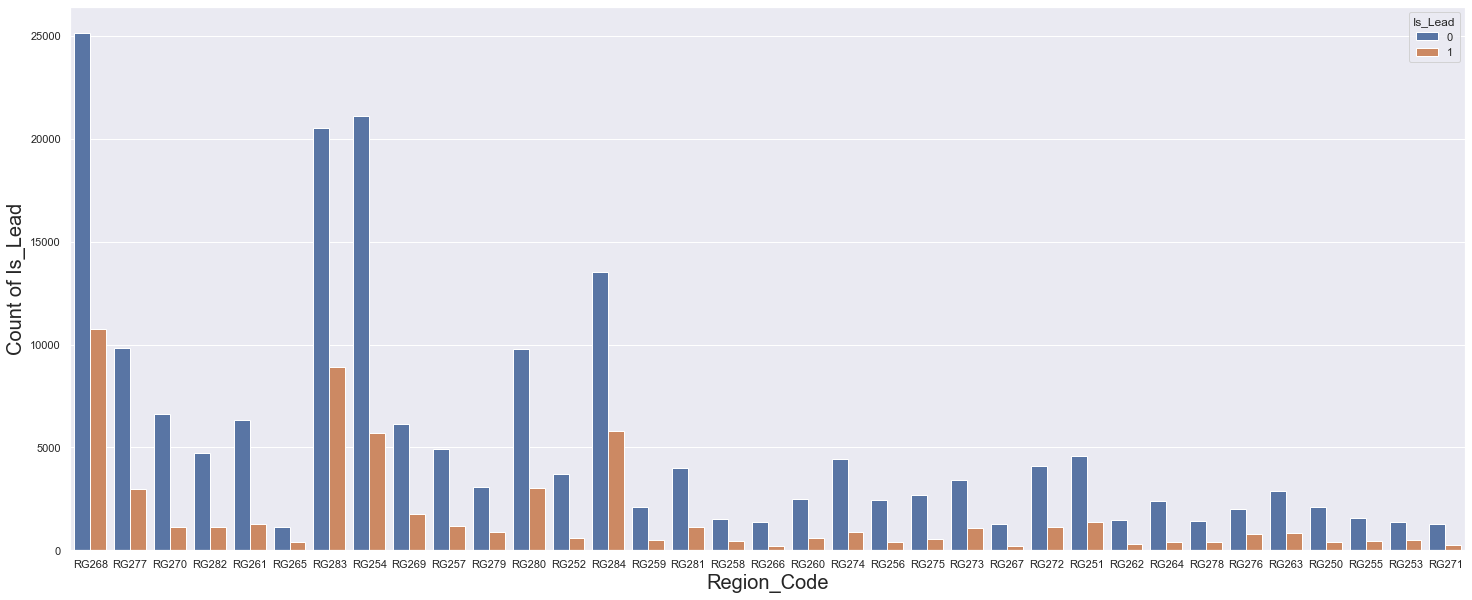

In [107]:
ax = plt.subplots(figsize=(25, 10))
sns.set_style("darkgrid")
sns.countplot(x='Region_Code', hue='Is_Lead', data=train_df);
plt.ylabel("Count of Is_Lead", size=20);
plt.xlabel("Region_Code", size=20);

In [108]:
# Response Rate from Cities
v = train_df.groupby('Region_Code').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)
# we create a new variable here names v which calculates the reponse ratio all regions using group by function. 
# we check for value 1 in the 0 and 1 for all the regions 

In [109]:
v['Ratio'].mean()

0.20724818735170963

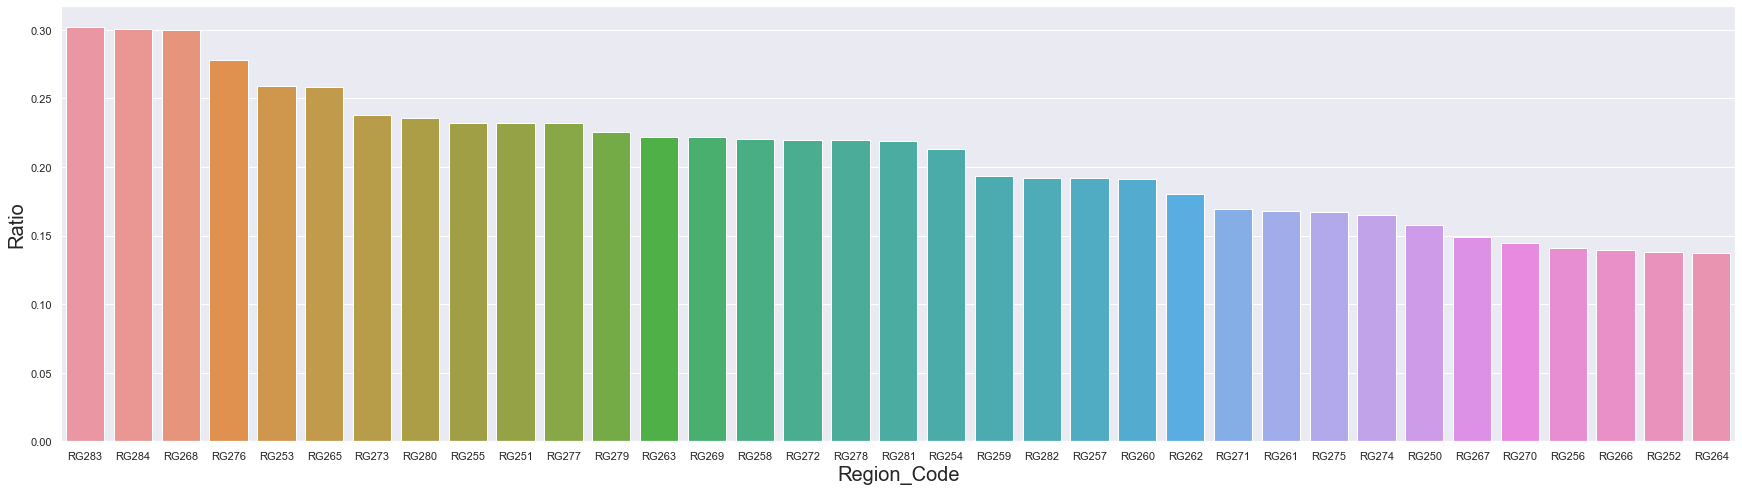

In [110]:
ax = plt.subplots(figsize=(30, 8))
sns.set_style("darkgrid")
sns.barplot(x='Region_Code', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));
plt.ylabel("Ratio", size=20);
plt.xlabel("Region_Code", size=20);

## 7. Occupation
Occupation Type for the customer

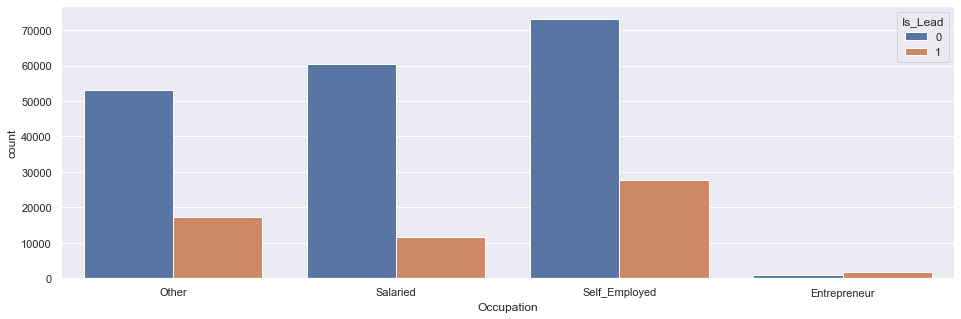

In [111]:
ax = plt.subplots(figsize=(16, 5))
sns.set_style("darkgrid")
sns.countplot(x='Occupation', hue='Is_Lead', data=train_df);

In [112]:
# Response Rate from Occupation
v = train_df.groupby('Occupation').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)
# we create a new variable here names v which calculates the reponse ratio all occupations using group by function. 
# we check for value 1 in the 0 and 1 for all the occupations 

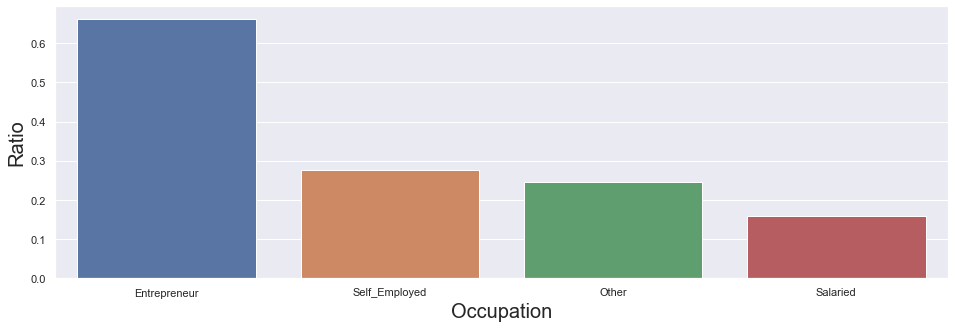

In [113]:
ax = plt.subplots(figsize=(16, 5))
sns.set_style("darkgrid")
sns.barplot(x='Occupation', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));
plt.ylabel("Ratio", size=20);
plt.xlabel("Occupation", size=20);

* The customer base in training data are majorly Self-Employed or Salaried.
* Entrepreneural customers are way more likely to respond positively to our Credit Card offer.
* Salaried people are least likely to respond positively to our offer.

## 8. Channel Code
Acquisition Channel Code for the Customer  (Encoded)

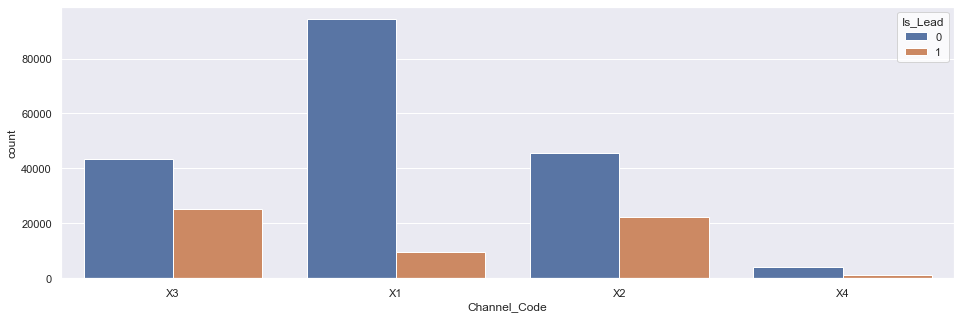

In [114]:
ax = plt.subplots(figsize=(16, 5))
sns.set_style("whitegrid")
sns.countplot(x='Channel_Code', hue='Is_Lead', data=train_df);

In [115]:
# Response Rate from Channel_Code
v = train_df.groupby('Channel_Code').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)

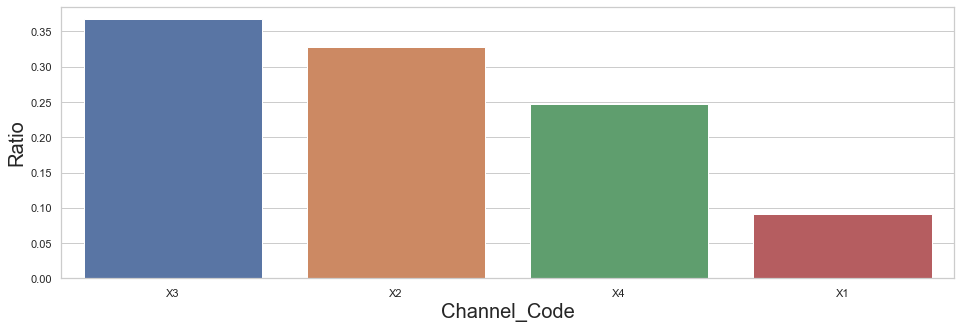

In [116]:
ax = plt.subplots(figsize=(16, 5))
sns.set_style("darkgrid")
sns.barplot(x='Channel_Code', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));
plt.ylabel("Ratio", size=20);
plt.xlabel("Channel_Code", size=20);

* Customer acquired through X3 channel are most likely to respond positively and X1 are least likely.

## 9. Vintage
Vintage for the Customer (In Months)

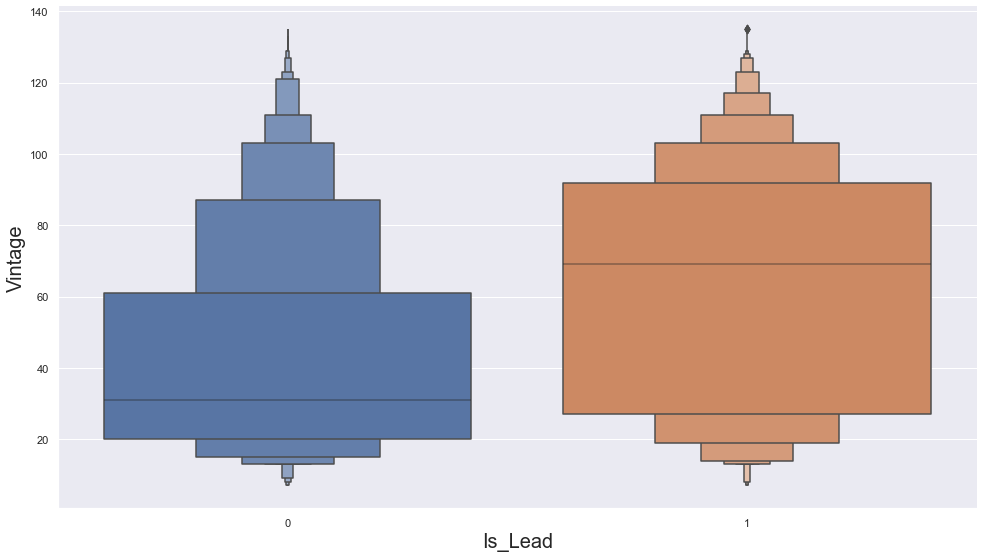

In [117]:
g = sns.catplot(x='Is_Lead', y='Vintage', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)
plt.ylabel("Vintage", size=20);
plt.xlabel("Is_Lead", size=20);

* Customers having a higher Vintage on an average are more likely to respond positively.

## 10. Credit Product
If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.)

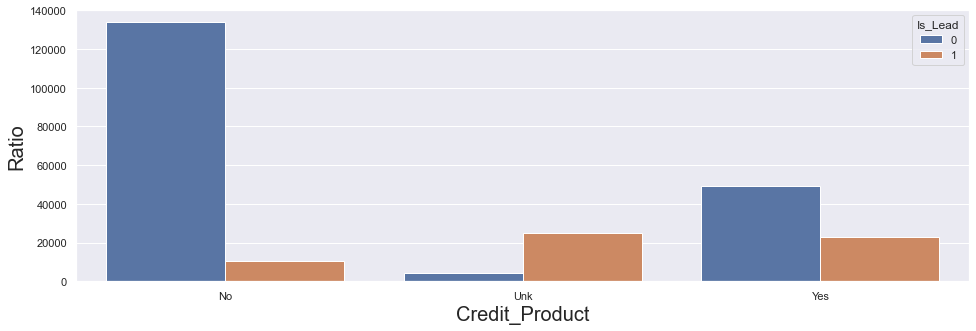

In [118]:
ax = plt.subplots(figsize=(16, 5))
sns.set_style("darkgrid")
sns.countplot(x='Credit_Product', hue='Is_Lead', data=train_df);
plt.ylabel("Ratio", size=20);
plt.xlabel("Credit_Product", size=20);

In [119]:
# Response Rate from Credit_Product
v = train_df.groupby('Credit_Product').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)

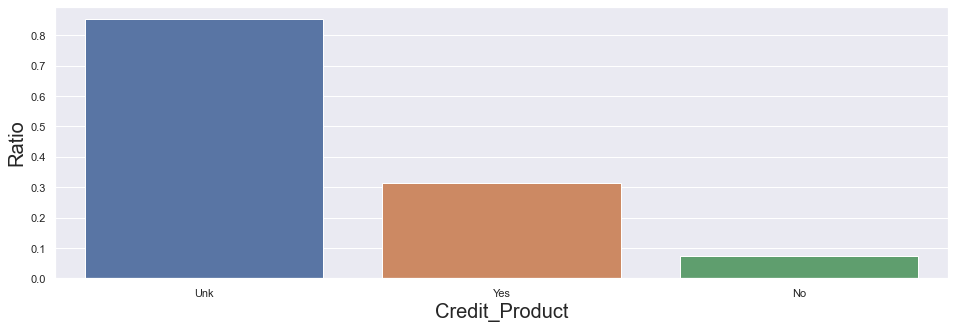

In [120]:
ax = plt.subplots(figsize=(16, 5))
sns.set_style("darkgrid")
sns.barplot(x='Credit_Product', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));
plt.ylabel("Ratio", size=20);
plt.xlabel("Credit_Product", size=20);

* People already having some kind of credit product are way more likely to respond positively to offer as compared to non-credit users.

## 11. Avg Account Balance
Average Account Balance for the Customer in last 12 Months

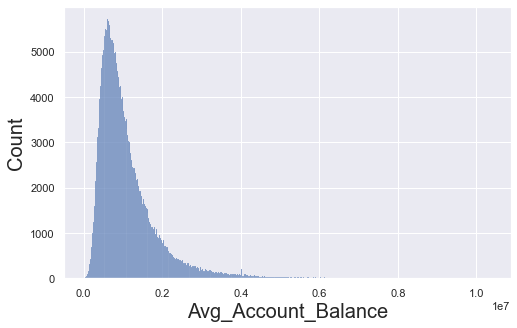

In [121]:
ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=train_df, x='Avg_Account_Balance');
plt.ylabel("Count", size=20);
plt.xlabel("Avg_Account_Balance", size=20);

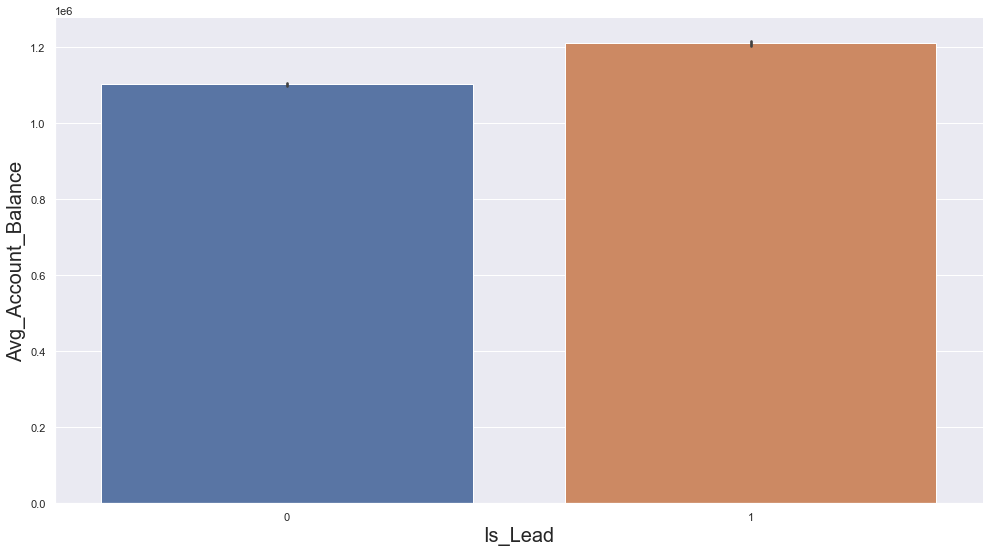

In [122]:
g = sns.catplot(x='Is_Lead', y='Avg_Account_Balance', kind='bar', data=train_df);
g.fig.set_size_inches(15,8)
plt.xlabel("Is_Lead", size=20);
plt.ylabel("Avg_Account_Balance", size=20);

* Positively responding customers have a slightly higher average account balance on an average as compared to negatively responding customers.

## 12. Is Active
If the Customer is Active in last 3 Months

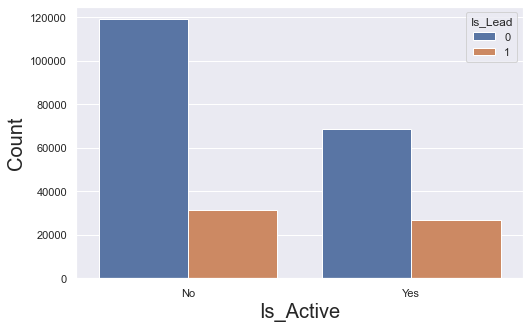

In [123]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(x='Is_Active', hue='Is_Lead', data=train_df);
plt.xlabel("Is_Active", size=20);
plt.ylabel("Count", size=20);

In [124]:
# Response Rate from Is_Active
v = train_df.groupby('Is_Active').Is_Lead.value_counts().unstack()
v['Ratio'] = v[1]/(v[0] + v[1])
v.reset_index(inplace=True)
# we create a new variable here names v which calculates the reponse ratio whether the customer is 
# active or not using group by function. 
# we check for value 1 in the 0 and 1 for whether customer is active or not  

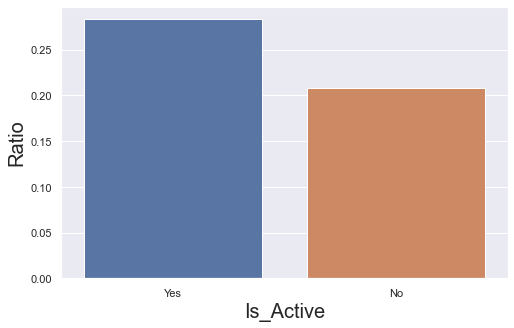

In [125]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("darkgrid")
sns.barplot(x='Is_Active', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));
plt.xlabel("Is_Active", size=20);
plt.ylabel("Ratio", size=20);

* Active Customers(in last 3 months) are slightly more likely to respond positively as compared to inactive customers.

In [126]:
target = ['Is_Lead']
not_features = ['ID', 'Is_Lead']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)
# create a list of columns that are not features and printing the list

['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Credit_Product_Known']


In [127]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_features = []
numerical_features = []

for i in features:
    if train_df[i].dtype in numerics:
        numerical_features.append(i)
    else:
        categorical_features.append(i)
        
print(f'Numeric features: {numerical_features}')
print(f'Categorical features: {categorical_features}')
# divide the numeric and categorical features into two arrays. 

Numeric features: ['Age', 'Vintage', 'Avg_Account_Balance', 'Credit_Product_Known']
Categorical features: ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']


## 13. Numerical Feature Interactions

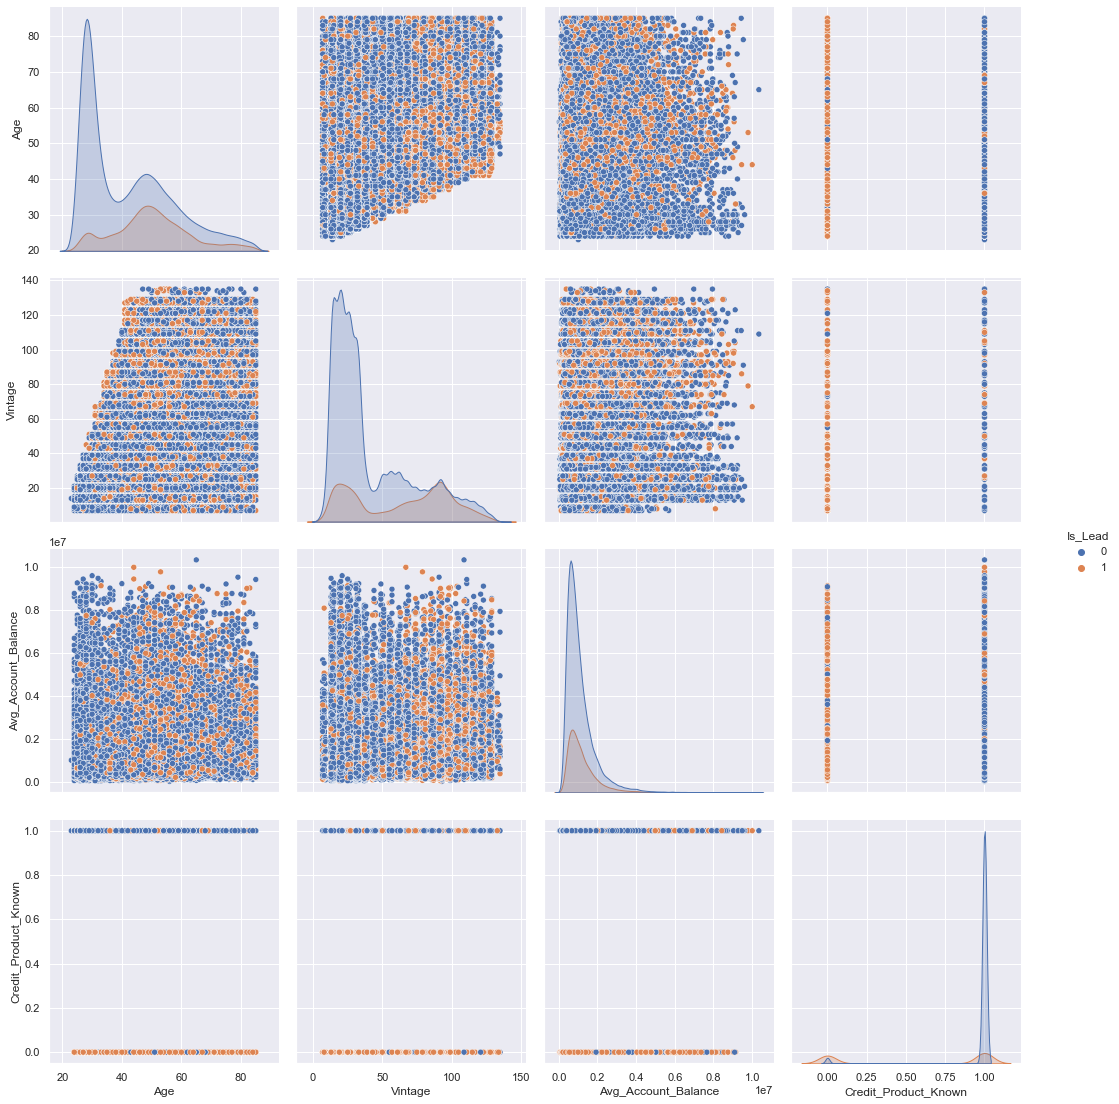

In [128]:
g = sns.pairplot(train_df[numerical_features + ['Is_Lead']], hue='Is_Lead' )
g.fig.set_size_inches(16,16)
# here we will check the interactions of the numeric features with our target variable Is_Lead

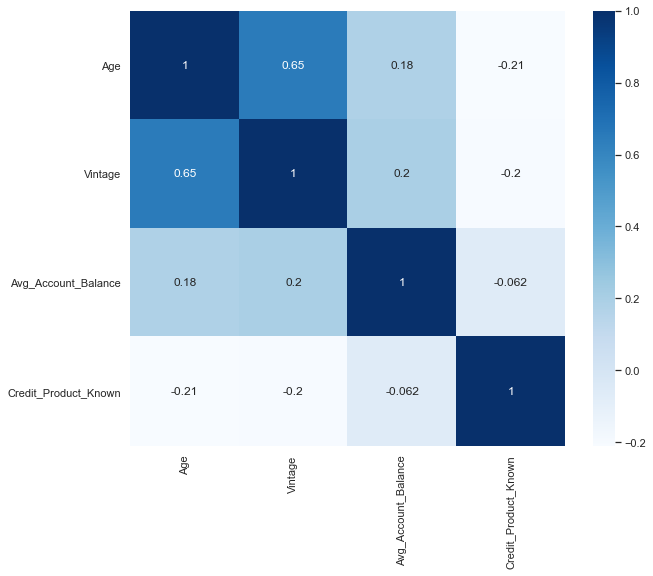

In [129]:
# checking for correlations between the numeric features 
train_df_cor_spear = train_df[numerical_features].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(train_df_cor_spear, square=True, cmap='Blues', annot=True);

# KFolds Split
Before we move on to feature engineering, it is always a good idea to perform cross validation splits. In that way, we will not rix any data leakage and would be more certain of the validation set being aptly represenative of the real world unknown data.

In [130]:
NUM_SPLITS = 5

train_df["kfold"] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df.Is_Lead.values
kf = StratifiedKFold(n_splits=NUM_SPLITS)
for f, (t_, v_) in enumerate(kf.split(X=train_df, y=y)):
    train_df.loc[v_, 'kfold'] = f
    
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Credit_Product_Known,kfold
0,FO27LBAN,Female,82,RG251,Other,X2,51,Yes,441769,No,0,1,0
1,AJ9PANHI,Male,52,RG280,Self_Employed,X3,62,No,661554,No,0,1,0
2,HY8ZRRB9,Male,31,RG284,Salaried,X1,25,Yes,2151922,No,0,1,0
3,ORLPS7JG,Female,33,RG268,Self_Employed,X1,27,No,2525072,No,0,1,0
4,D2JZQYRX,Male,30,RG251,Salaried,X1,19,No,2156763,No,0,1,0


# Feature Encoding

First let's convert all the categorical features to numbers. I have decided to use Label encoder after lot of experiments with other types of categorical encoders and decision is made based on CV ROC score.

In [131]:
def label_enc(train_df, test_df, features):
    lbl_enc = preprocessing.LabelEncoder()
    full_data = pd.concat(
        [train_df[features], test_df[features]],
        axis=0
    )
    
    for col in (features):
        print(col)
        if train_df[col].dtype == 'object':
            lbl_enc.fit(full_data[col].values)
            train_df[col] = lbl_enc.transform(train_df[col])
            test_df[col] = lbl_enc.transform(test_df[col])
            
    return train_df, test_df

In [132]:
mapping_dict = {'Yes': 1,
                'No': 0,
                'Unk': 0.5}

In [133]:
train_df['Credit_Product'] = train_df['Credit_Product'].map(mapping_dict)
test_df['Credit_Product'] = test_df['Credit_Product'].map(mapping_dict)

train_df['Is_Active'] = train_df['Is_Active'].map(mapping_dict)
test_df['Is_Active'] = test_df['Is_Active'].map(mapping_dict)

In [134]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Credit_Product_Known,kfold
0,FO27LBAN,Female,82,RG251,Other,X2,51,1.0,441769,0.0,0,1,0
1,AJ9PANHI,Male,52,RG280,Self_Employed,X3,62,0.0,661554,0.0,0,1,0
2,HY8ZRRB9,Male,31,RG284,Salaried,X1,25,1.0,2151922,0.0,0,1,0
3,ORLPS7JG,Female,33,RG268,Self_Employed,X1,27,0.0,2525072,0.0,0,1,0
4,D2JZQYRX,Male,30,RG251,Salaried,X1,19,0.0,2156763,0.0,0,1,0


In [135]:
target = ['Is_Lead']
not_features = ['ID', 'Is_Lead', 'kfold']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Credit_Product_Known']


In [136]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_features = []
numerical_features = []

for i in features:
    if train_df[i].dtype in numerics:
        numerical_features.append(i)
    else:
        categorical_features.append(i)
        
print(f'Numeric features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

Numeric features: ['Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Credit_Product_Known']
Categorical features: ['Gender', 'Region_Code', 'Occupation', 'Channel_Code']


In [137]:
train_df[numerical_features] = train_df[numerical_features].astype('float64')
test_df[numerical_features] = test_df[numerical_features].astype('float64')

In [138]:
train_df[target] = train_df[target].astype('float64')

In [139]:
cutoff = 10
low_cardinal_columns = []
high_cardinal_columns = []

for i in categorical_features:
    if train_df[i].nunique() > cutoff:
        high_cardinal_columns.append(i)
    else:
        low_cardinal_columns.append(i)
        
print(f'High Cardinality columns: {high_cardinal_columns}')
print(f'Low Cardinality columns: {low_cardinal_columns}')

High Cardinality columns: ['Region_Code']
Low Cardinality columns: ['Gender', 'Occupation', 'Channel_Code']


In [140]:
if len(low_cardinal_columns) > 0:
    train_df, test_df = label_enc(train_df, test_df, low_cardinal_columns)

Gender
Occupation
Channel_Code


In [141]:
if len(high_cardinal_columns) > 0:
    train_df, test_df = label_enc(train_df, test_df, high_cardinal_columns)

Region_Code


# Clustering
We can cluster the customers to some groups using the given features and use them as one of the features to identify what cluster the customer belongs to.

In [142]:
kmeans = KMeans(n_clusters=3, random_state=42, n_jobs=-1)
kmeans.fit(train_df[features])

train_df['cluster'] = kmeans.predict(train_df[features])
test_df['cluster'] = kmeans.predict(test_df[features])

# Feature Selection

We need to select only the important features for better performance of the model. As unnecessary in best case scenario will not add to any productive calculation of the algorithm or in worst case scenario 'confuse' the model.

To do the same let's create a wrapper class that has all the built in statistical tests required to perform feature selection and takes some basic inputs from user and spits out the required features.

In [143]:
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features+target]

In [144]:
class UnivariateFeatureSelction:
    def __init__(self, n_features, problem_type, scoring, return_cols=True):
        """
        Custom univariate feature selection wrapper on
        different univariate feature selection models from
        scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """
        self.n_features = n_features
        
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
            
        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring],
                k=n_features
            )
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                valid_scoring[scoring],
                percentile=int(n_features * 100)
            )
        else:
            raise Exception("Invalid type of feature")
    
    def fit(self, X, y):
        return self.selection.fit(X, y)
    
    def transform(self, X):
        return self.selection.transform(X)
    
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)
    
    def return_cols(self, X):
        if isinstance(self.n_features, int):
            mask = SelectKBest.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
                    
        elif isinstance(self.n_features, float):
            mask = SelectPercentile.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
        else:
            raise Exception("Invalid type of feature")
        
        return selected_features

In [145]:
ufs = UnivariateFeatureSelction(
    n_features=1.0,
    problem_type="classification",
    scoring="f_classif"
)

ufs.fit(train_df[features], train_df[target].values.ravel())
selected_features = ufs.return_cols(train_df[features])

Through iterations it has been found that all features are important. Hence we are not doing any feature selection and thus the n_features parameter has value 1.0

In [146]:
print(f'{len(selected_features)} Features Selected')
print(selected_features)

11 Features Selected
['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Credit_Product_Known', 'cluster']


# Models Benchmarking
First let's create a benchmarking function which finds the best single model for this dataset.

In [147]:
def get_models():
    models = dict()
    models['gauss'] = GaussianNB()
    models['QDA'] = QuadraticDiscriminantAnalysis()
    models['lr'] = LogisticRegression(solver='liblinear')
    models['rf'] = RandomForestClassifier(class_weight='balanced_subsample',
                                          random_state=42)
    models['lgbm'] = LGBMClassifier(metric='binary_logloss',
                                    objective='binary',
                                    reg_alpha=2.945525898790487,
                                    max_depth=13,
                                    num_leaves=34,
                                    seed=42,
                                    learning_rate=0.0037601596530868493,
                                    n_estimators=1913)
    models['BalBag'] = BalancedBaggingClassifier()
    models['BalRF'] = BalancedRandomForestClassifier()
    
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv,
                             n_jobs=-1, error_score='raise')
    return scores

In [148]:
%%time

X = train_df[selected_features].values
y = train_df[target].values

models = get_models()
results = []
names = []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print(f'{name} : {round(np.mean(scores),6)} ({round(np.std(scores),3)})')

gauss : 0.693042 (0.002)
QDA : 0.852897 (0.002)
lr : 0.447428 (0.002)
rf : 0.855313 (0.002)
lgbm : 0.873972 (0.002)
BalBag : 0.840287 (0.002)
BalRF : 0.862776 (0.002)
Wall time: 14min 54s


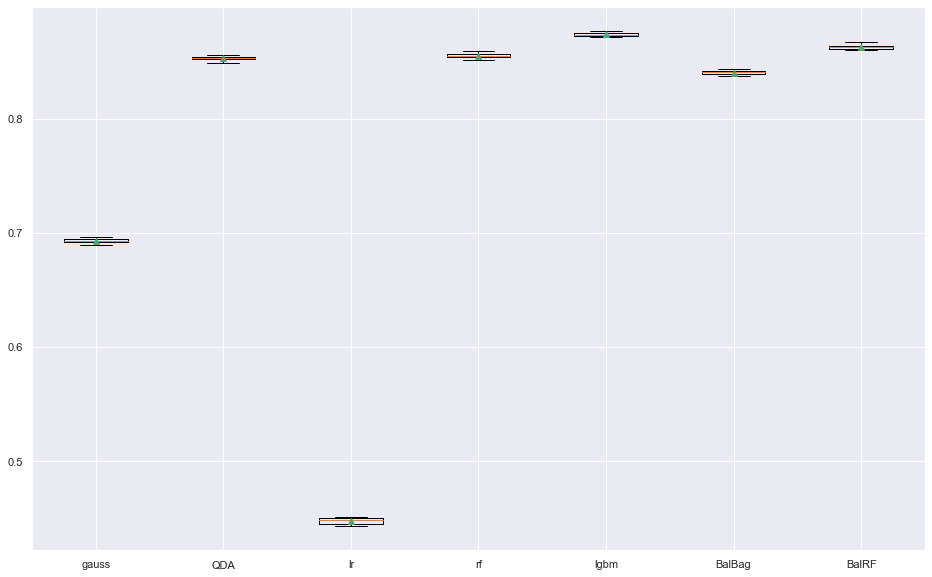

In [149]:
ax = plt.subplots(figsize=(16, 10))
plt.boxplot(results, labels=names, showmeans=True, widths= 0.5)
plt.show()

# Best Model
Prediction using the best single model.

In [150]:
mean_scores = []
for score in results:
    mean_scores.append(round(np.mean(score),3))
min_index = mean_scores.index(max(mean_scores))
model_name = names[min_index]

In [151]:
print(f'Best Score: {mean_scores[min_index]}')
print(f'Best Model: {model_name}')

Best Score: 0.874
Best Model: lgbm


In [152]:
%%time

models = get_models()
clf = models[model_name]
X = train_df[selected_features]
y = train_df[target]
clf.fit(X, y)

preds = clf.predict_proba(test_df[selected_features])
sub = pd.DataFrame()
sub['ID'] = test_df['ID']
sub['Is_Lead'] = preds[:, 1]

Wall time: 20.1 s


In [153]:
sub.head()

,ID,Is_Lead
0,VBENBARO,0.039830
1,CCMEWNKY,0.864890
2,VK3KGA9M,0.057406
3,TT8RPZVC,0.022580
4,SHQZEYTZ,0.022790


In [154]:
#sub.to_csv('Best_single_Model.csv', index=False)

# Final Solution
Creating a custom ensemble using the best single model from above and training on folds while tracking the OOF scores.

In [155]:
test_pred_all = None

for i in tqdm(range(NUM_SPLITS)):
    print('#'*50)
    print(f'{"*"*21} FOLD {i+1} {"*"*21}')
    
    train = train_df[train_df['kfold'] != i]
    valid = train_df[train_df['kfold'] == i]
    test = test_df
    
    clf = LGBMClassifier(metric='binary_logloss',
                         objective='binary',
                         reg_alpha=2.945525898790487,
                         max_depth=13,
                         num_leaves=34,
                         seed=42,
                         learning_rate=0.0037601596530868493,
                         n_estimators=20000)
    clf.fit(train[selected_features].values,train[target].values,
           eval_set=(valid[selected_features].values,valid[target].values),
           eval_metric='binary_logloss',
           early_stopping_rounds=500,
           verbose=1000)
    
    pred = clf.predict_proba(valid[selected_features])[:, 1]
    roc = roc_auc_score(valid[target], pred)

    test_pred = clf.predict_proba(test[selected_features])[:, 1]
    if test_pred_all is None:
        test_pred_all = test_pred
    else:
        test_pred_all += test_pred
    
    print(f'ROC: {roc}')
    print('#'*50)
    
test_pred_all /= NUM_SPLITS

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

##################################################
********************* FOLD 1 *********************
[1000]	valid_0's binary_logloss: 0.348484
[2000]	valid_0's binary_logloss: 0.34638
[3000]	valid_0's binary_logloss: 0.346343


 20%|████████████████▊                                                                   | 1/5 [00:30<02:02, 30.66s/it]

ROC: 0.8719478323195247
##################################################
##################################################
********************* FOLD 2 *********************
[1000]	valid_0's binary_logloss: 0.345372
[2000]	valid_0's binary_logloss: 0.343115


 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:21, 27.28s/it]

ROC: 0.873979607705686
##################################################
##################################################
********************* FOLD 3 *********************
[1000]	valid_0's binary_logloss: 0.342297
[2000]	valid_0's binary_logloss: 0.339797
[3000]	valid_0's binary_logloss: 0.339745


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.63s/it]

ROC: 0.8770273780688645
##################################################
##################################################
********************* FOLD 4 *********************
[1000]	valid_0's binary_logloss: 0.347987
[2000]	valid_0's binary_logloss: 0.345753
[3000]	valid_0's binary_logloss: 0.345689


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:05<00:33, 33.09s/it]

ROC: 0.872366272312081
##################################################
##################################################
********************* FOLD 5 *********************
[1000]	valid_0's binary_logloss: 0.346194
[2000]	valid_0's binary_logloss: 0.343759
[3000]	valid_0's binary_logloss: 0.343593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.49s/it]

ROC: 0.8748091709935398
##################################################


In [156]:
sub_2 = pd.DataFrame()
sub_2['ID'] = test_df['ID']
sub_2['Is_Lead'] = test_pred_all

In [157]:
sub_2.head()

,ID,Is_Lead
0,VBENBARO,0.040338
1,CCMEWNKY,0.863693
2,VK3KGA9M,0.061764
3,TT8RPZVC,0.022568
4,SHQZEYTZ,0.023227


In [158]:
sub_2.to_csv('LGBM_5fold_Ensemble.csv', index=False)